In [ ]:
!pip install git+https://github.com/votchallenge/vot-toolkit-python
!vot 'initialize' vot2017 --workspace /content/drive/MyDrive/Assignment4/vot-workspace

# Imports

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
import datetime
import random
import sys
from matplotlib import pyplot as plt
from IPython.display import display
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
import torchvision.transforms.functional as F
import torch.optim as optim
import torch.nn.functional as F1


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


# Dataset Setup

In [3]:
class_image_paths = []
groundTruths = []
path = "/content/drive/MyDrive/Assignment4/vot-workspace/sequences"
class_image_paths = []
class_count = 0
for dir in os.listdir(path):
    try:
      class_count += 1
      dirPath = path + "/" + dir
      groundtruth = open(dirPath + "/groundtruth.txt", "r")
      count = 0
      for img in sorted(os.listdir(dirPath + "/color/")):
          imgPath = dirPath + "/color/" + img
          count += 1
          class_image_paths.append([imgPath, class_count-1])
          tempImg = Image.open(imgPath)
          
          groundTruths.append([imgPath, class_count-1, groundtruth.readline().strip(), tempImg])
          
      groundtruth.close()
    except:
      continue

pairElements = []
for i in range(len(groundTruths) - 1):
  if (groundTruths[i][1] == groundTruths[i + 1][1]):
    pairElements.append([groundTruths[i], groundTruths[i + 1]])


random.shuffle(pairElements)




# Model Setup

In [4]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.linear1 = nn.Linear(1024, 1024)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(1024, 4)

       


    def forward(self, x):
        residual = x
        out = F1.relu(self.linear1(x))
        out = F1.relu(self.linear1(out))
        out = self.linear2(x+residual)
        return out



model = models.resnet18(pretrained=True)
model.fc = nn.Sequential()
myModel = MyModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(myModel.parameters(),lr= 0.001)




Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


# Crop The First Frame & Train

In [22]:


def cropImage(image):

    # This part opens image and takes groundTruth, draw BB and crop image according to enlarged BB
    firstFrame = cv2.imread(image[0][0])
    groundTruthString = image[0][2]
    coordinates = groundTruthString.split(",")
    xCoordinatesOfGroundTruth = []
    yCoordinatesOfGroundTruth = []
    for i in range(0, len(coordinates), 2):
      xCoordinatesOfGroundTruth.append(round(float((coordinates[i]))))
      yCoordinatesOfGroundTruth.append(round(float((coordinates[i+1]))))

    x_of_left_upper = min(xCoordinatesOfGroundTruth)
    y_of_left_upper = min(yCoordinatesOfGroundTruth)

    x_of_right_bottom = max(xCoordinatesOfGroundTruth)
    y_of_right_bottom = max(yCoordinatesOfGroundTruth)

    X_of_center_bounding_box = (x_of_left_upper + x_of_right_bottom) // 2
    Y_of_center_bounding_box = (y_of_left_upper + y_of_right_bottom) // 2

    xDiff = abs(X_of_center_bounding_box - x_of_left_upper)
    yDiff = abs(Y_of_center_bounding_box - y_of_left_upper)

    leftUpper = (x_of_left_upper, y_of_left_upper)
    rightLower = (x_of_right_bottom, y_of_right_bottom)

    cv2.rectangle(firstFrame, leftUpper, rightLower, (0, 255, 0), 1)    
    croppedFirstImage = firstFrame[max(0, y_of_left_upper-yDiff):y_of_right_bottom+yDiff, max(0, x_of_left_upper-xDiff):x_of_right_bottom+xDiff]
    




    # This part crops second frame according to first frames coordinates
    secondFrame = cv2.imread(image[1][0])

    croppedSecondFrame = secondFrame[max(0, y_of_left_upper-yDiff):y_of_right_bottom+yDiff, max(0, x_of_left_upper-xDiff):x_of_right_bottom+xDiff]

    cropped_X_Coordinates = [max(0, x_of_left_upper-xDiff), x_of_right_bottom+xDiff]
    cropped_Y_Coordinates = [max(0, y_of_left_upper-yDiff), y_of_right_bottom+yDiff]

    targetVector = []

    predictGroundTruthString = image[1][2]
    predictCoordinates = predictGroundTruthString.split(",")
    x_coord_of_predict = []
    y_coord_of_predict = []
    for i in range(0, len(predictCoordinates), 2):
      x_coord_of_predict.append((round(float((predictCoordinates[i])))))
      y_coord_of_predict.append((round(float((predictCoordinates[i+1])))))
  
    x_of_left_upper = min(x_coord_of_predict)
    y_of_left_upper = min(y_coord_of_predict)

    x_of_right_bottom = max(x_coord_of_predict)
    y_of_right_bottom = max(y_coord_of_predict)

    X_of_center_bounding_box = (x_of_left_upper + x_of_right_bottom) // 2
    Y_of_center_bounding_box = (y_of_left_upper + y_of_right_bottom) // 2

    leftUpper = (x_of_left_upper, y_of_left_upper)
    rightLower = (x_of_right_bottom, y_of_right_bottom)



    # This part calculates target vector values
    bigX = cropped_X_Coordinates[1]
    bigY = cropped_Y_Coordinates[1]
    smallX = cropped_X_Coordinates[0]
    smallY = cropped_Y_Coordinates[0]


    leftUpperX = leftUpper[0]
    leftUpperY = leftUpper[1]
    rightLowerX = rightLower[0]
    rightLowerY = rightLower[1]

    
    c = 224 * (bigX-rightLowerX) // (bigX - smallX)
    d = 224 * (bigY-rightLowerY) // (bigY - smallY)

    a = 224 * (bigX-leftUpperX) // (bigX - smallX)
    b = 224 * (bigY-leftUpperY) // (bigY - smallY)

    resultFrame = cv2.resize(croppedFirstImage, (224, 224))
    cv2.rectangle(resultFrame, (a, b), (c, d), (0, 0, 255), 2)    

    targetVector.append([abs(a), abs(b), abs(c), abs(d)])
    
    cropCord = [smallX, smallY, bigX, bigY]

    return torch.tensor(cv2.resize(croppedFirstImage, (224, 224))).unsqueeze(1).permute(1, 3, 0, 2).to(torch.float32), torch.tensor(cv2.resize(croppedSecondFrame, (224, 224))).unsqueeze(1).permute(1, 3, 0, 2).to(torch.float32), targetVector, cropCord








random.shuffle(pairElements)
trainSet = pairElements[0:14197]
testSet = pairElements[14197:]




epoch = 30
for i in range(epoch):  
  epoch_loss = []
  start_time = time()  
  for j in range(len(trainSet)):

    firstFrame, secondFrame, targetVector, _ = cropImage(trainSet[j])
    targetVector = torch.tensor(targetVector).to(torch.float32)

    output1 = model(firstFrame)
    output2 = model(secondFrame)
    resultVector = torch.cat((output1, output2), 1)
    output3 = myModel(resultVector.to(device))

    
    loss = criterion(output3.to(device), targetVector.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss.append(loss.item())
    
    
    
  end_time = time()
  print("Epoch = ", i, "Loss = ", sum(epoch_loss)/len(epoch_loss))
  



Epoch =  0 Loss =  527.1806200027465
Epoch =  1 Loss =  443.37292938232423
Epoch =  2 Loss =  425.6424850463867
Epoch =  3 Loss =  416.36414947509763
Epoch =  4 Loss =  416.35582733154297


# Testing

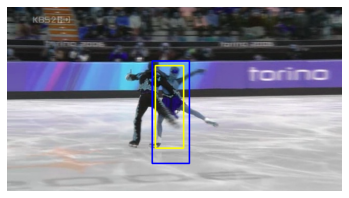

In [35]:

test_loss = 0
start_time = time()

accuracy = []




with torch.no_grad():
    for i in range(len(testSet)):
        firstFrame, secondFrame, targetVector, cropCord = cropImage(testSet[i])

        targetVector = torch.tensor(targetVector).to(torch.float32)

        output1 = model(firstFrame)
        output2 = model(secondFrame)
        resultVector = torch.cat((output1, output2), 1)

        output3 = myModel(resultVector.to(device))
        
        output3 = output3.tolist()[0]
        
        originalSecondFrame = cv2.imread(testSet[i][1][0])

        croppedBoxedSecondFrame = originalSecondFrame[cropCord[1]:cropCord[3], cropCord[0]:cropCord[2]]
        
        myShape = croppedBoxedSecondFrame.shape
        croppedBoxedSecondFrame = cv2.resize(croppedBoxedSecondFrame, (224,224))


        a = int(round(output3[0]))
        b = int(round(output3[1]))
        c = int(round(output3[2]))
        d = int(round(output3[3]))


        drawedRectangle = cv2.rectangle(croppedBoxedSecondFrame, (a,b), (c,d), (255,255,0), 3)

        finalCordX1 = (a * myShape[1] // 224) + cropCord[0]
        finalCordY1 = (b * myShape[0] // 224) + cropCord[1]
        finalCordX2 = (c * myShape[1] // 224) + cropCord[0]
        finalCordY2 = (d * myShape[0] // 224) + cropCord[1]

        drawedRectangle = cv2.rectangle(originalSecondFrame, (finalCordX1,finalCordY1), (finalCordX2,finalCordY2), (0, 0, 255), 2)        
        
        coordinates = testSet[i][1][2].split(",")
        
        xCoordinatesOfGroundTruth = []
        yCoordinatesOfGroundTruth = []
        for j in range(0, len(coordinates), 2):
          xCoordinatesOfGroundTruth.append(round(float((coordinates[j]))))
          yCoordinatesOfGroundTruth.append(round(float((coordinates[j+1]))))

        x_of_left_upper = min(xCoordinatesOfGroundTruth)
        y_of_left_upper = min(yCoordinatesOfGroundTruth)

        x_of_right_bottom = max(xCoordinatesOfGroundTruth)
        y_of_right_bottom = max(yCoordinatesOfGroundTruth)

        X_of_center_bounding_box = (x_of_left_upper + x_of_right_bottom) // 2
        Y_of_center_bounding_box = (y_of_left_upper + y_of_right_bottom) // 2

        xDiff = abs(X_of_center_bounding_box - x_of_left_upper)
        yDiff = abs(Y_of_center_bounding_box - y_of_left_upper)

        leftUpper = (x_of_left_upper, y_of_left_upper)
        rightLower = (x_of_right_bottom, y_of_right_bottom)

        cv2.rectangle(originalSecondFrame, leftUpper, rightLower, (255, 255, 0), 2)
        


        # there is break for seeing single image if you want see test  please comment imshow and break
        plt.axis("off")
        plt.imshow(originalSecondFrame)
        
        break

        
        


  